In [1]:
# -------------------------------------------
# 1. LOAD CLEANED DATASET SAVED BY THE PRIOR MODULE
# -------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pathlib import Path
import warnings


# Import config paths
import sys
sys.path.append('..')
from config import CLEAN_DATA_DIR

# Loading from files, done below, is intended to make this module portable.

# The primary dataframe df created by the previous module was exported via to-parquet.  Retrieve it here.
df = pd.read_parquet(CLEAN_DATA_DIR / "DryBean_clean.parquet")

print(f"Reloaded dataframe: shape = {df.shape}")

warnings.filterwarnings("ignore")

# Load lists from exports (so notebook is portable)
# Also, the "clean_data" folder is where this pipeline saves files, including .txt informational files.
DATASET_NAME = "DryBean"
clean_dir = CLEAN_DATA_DIR

numericals_file = clean_dir / f"{DATASET_NAME}_numericals.txt"
categoricals_file = clean_dir / f"{DATASET_NAME}_categoricals.txt"

# Safely load numericals and feature files as lists.
if numericals_file.stat().st_size == 0:
    print("⚠️ Numericals file is empty.")
    numericals = []
else:
    numericals = pd.read_csv(numericals_file, header=None)[0].tolist()

if categoricals_file.stat().st_size == 0:
    print("⚠️ Categoricals file is empty.")
    categoricals = []
else:
    categoricals = pd.read_csv(categoricals_file, header=None)[0].tolist()

print(f"{len(numericals)} numerical features")
print(f"{len(categoricals)} categorical features")

Reloaded dataframe: shape = (13611, 17)
⚠️ Categoricals file is empty.
16 numerical features
0 categorical features


In [2]:
# -------------------------------------------
# 2. IDENTIFY DATA QUALITY ISSUES
# -------------------------------------------


# Calculate the % of missing values for each feature (i.e., in each column).
# Determine any numerical feature with no predictive value (constant features).
missing_percent = df[numericals].isnull().mean().sort_values(ascending=False)
constant_features = [col for col in numericals if df[col].nunique() <= 1]

print("Missing value summary:")
display(missing_percent[missing_percent > 0].to_frame("Missing_Pct"))

if constant_features:
    print("⚠️ Constant-value features:", constant_features)
else:
    print("No constant-value features found.")

Missing value summary:


,Missing_Pct


No constant-value features found.


In [3]:
# -------------------------------------------
# 3. ID FEATURES WITH LITTLE VARIATION IN THEIR VALUES
# -------------------------------------------

from sklearn.feature_selection import VarianceThreshold
import sklearn
print(sklearn.__version__)

# A very low-variance feature may not discriminate well between target values.
# Features with low variance might not be considered useful for modeling. But not a hard rule. 

# Set the threshold, below whch features are considered low variance.
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[numericals])

low_variance_features = [feature for feature, keep in zip(numericals, selector.get_support()) if not keep]

print("Low-variance features (variance < 0.01):")
print(low_variance_features if low_variance_features else "None detected.")

# Save low-variance features to .txt for downstream use
pd.Series(low_variance_features).to_csv(
    clean_dir / f"{DATASET_NAME}_low_variance_features.txt",
    index=False,
    header=False
)
print("Saved the list of low-variance features in a .txt file.")

1.7.0
Low-variance features (variance < 0.01):
['CO', 'Ec', 'Ex', 'R', 'S', 'SF1', 'SF2', 'SF3', 'SF4']
Saved the list of low-variance features in a .txt file.


Highly correlated feature pairs (r > 0.90):
  C ↔ A: 1.00
  Ed ↔ A: 0.98
  Ed ↔ C: 0.99
  K ↔ Ec: 0.92
  L ↔ A: 0.93
  L ↔ C: 0.93
  L ↔ Ed: 0.96
  P ↔ A: 0.97
  P ↔ C: 0.97
  P ↔ Ed: 0.99
  P ↔ L: 0.98
  SF3 ↔ CO: 1.00
  l ↔ A: 0.95
  l ↔ C: 0.95
  l ↔ Ed: 0.95
  l ↔ P: 0.91


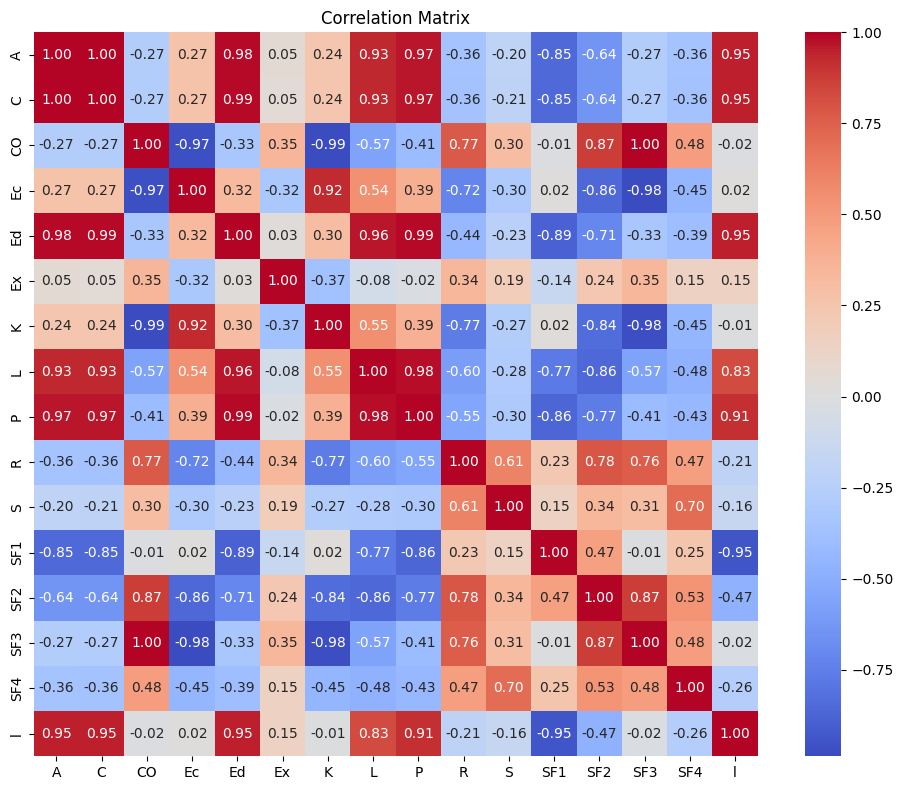

Strongest negatively correlated feature pairs (r < -0.90):
  CO ↔ K: -0.99
  K ↔ CO: -0.99
  Ec ↔ SF3: -0.98
  SF3 ↔ Ec: -0.98
  K ↔ SF3: -0.98
  SF3 ↔ K: -0.98
  CO ↔ Ec: -0.97
  Ec ↔ CO: -0.97
  SF1 ↔ l: -0.95
  l ↔ SF1: -0.95
Feature pairs with near-zero correlation (-0.10 ≤ r ≤ 0.10):
  SF1 ↔ SF3: -0.01
  SF3 ↔ SF1: -0.01
  K ↔ l: -0.01
  l ↔ K: -0.01
  CO ↔ SF1: -0.01
  SF1 ↔ CO: -0.01
  CO ↔ l: -0.02
  l ↔ CO: -0.02
  SF3 ↔ l: -0.02
  l ↔ SF3: -0.02


In [4]:
# -------------------------------------------
# 4. ID HIGHLY CORRELATED FEATURES
# -------------------------------------------


# Determine corrleation between every pair of numerical features.
corr = df[numericals].corr()
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find and display those pairs with a very high correlation (absolute value > 0.90).
high_corr_pairs = [(col, idx, upper_tri.loc[idx, col])
                   for col in upper_tri.columns
                   for idx in upper_tri.index
                   if pd.notnull(upper_tri.loc[idx, col]) and upper_tri.loc[idx, col] > 0.9]

print("Highly correlated feature pairs (r > 0.90):")
for a, b, val in high_corr_pairs:
    print(f"  {a} ↔ {b}: {val:.2f}")

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


# Find and display those pairs with a very strong negative correlation (correlation < -0.90), sorted from most negative to least.
neg_corr_pairs = [
    (col, idx, corr.loc[idx, col])
    for col in corr.columns
    for idx in corr.index
    if pd.notnull(corr.loc[idx, col]) and corr.loc[idx, col] < -0.90
]

# Sort by correlation value (ascending: most negative first)
neg_corr_pairs_sorted = sorted(neg_corr_pairs, key=lambda x: x[2])

print("Strongest negatively correlated feature pairs (r < -0.90):")
for a, b, val in neg_corr_pairs_sorted[:10]:  # Show the 10 most negative
    print(f"  {a} ↔ {b}: {val:.2f}")


# Find and display those pairs with near-zero correlation (r between -0.10 and 0.10)
near_zero_corr_pairs = [
    (col, idx, corr.loc[idx, col])
    for col in corr.columns
    for idx in corr.index
    if pd.notnull(corr.loc[idx, col]) and col != idx and -0.10 <= corr.loc[idx, col] <= 0.10
]

# Sort by absolute correlation value (lowest first)
near_zero_corr_pairs_sorted = sorted(near_zero_corr_pairs, key=lambda x: abs(x[2]))

print("Feature pairs with near-zero correlation (-0.10 ≤ r ≤ 0.10):")
for a, b, val in near_zero_corr_pairs_sorted[:10]:  # Show the 10 closest to zero
    print(f"  {a} ↔ {b}: {val:.2f}")


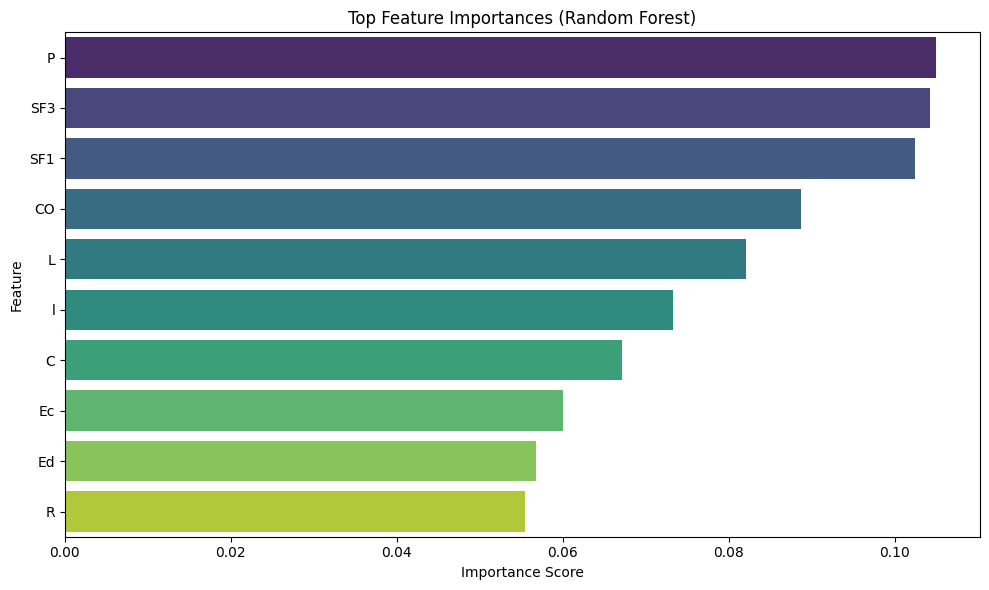

Ranking of all feature importances:


,importance
P,0.104993
SF3,0.104163
SF1,0.102384
CO,0.088684
L,0.081993
l,0.073249
C,0.067083
Ec,0.059967
Ed,0.056802
R,0.055443


In [5]:
# -------------------------------------------
# 5. DETERMINE PREDICTIVE POWER OF FEATURES
# -------------------------------------------


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Create a clean copy of the data (fill in nulls, encode labels)
df_encoded = df.copy()
imputer = SimpleImputer(strategy="median")  # Filling in with median is robust to outliers

X = pd.DataFrame(imputer.fit_transform(df_encoded[numericals]), columns=numericals)
y = LabelEncoder().fit_transform(df_encoded["Class"]) # Req'd for RandomForestClassifier. Update if label is named differently

# Train a Random Forest model to determine feature importances.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get imporance scores, rank from most to least important, and select the top 10 features.
importances = pd.Series(model.feature_importances_, index=numericals).sort_values(ascending=False)
top_n = importances[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_n.values, y=top_n.index, palette="viridis")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")  
plt.tight_layout()
plt.show()

print("Ranking of all feature importances:")
display(importances.to_frame("importance"))

In [6]:
# -------------------------------------------
# 6. GENERATE A DECISION BRIEF
# -------------------------------------------

# Combine all metrics for each feature in one table.
decisions = pd.DataFrame({
    "missing_pct": df[numericals].isnull().mean() * 100,
    "variance": df[numericals].var(),
    "importance": importances
})

# And add warning flags for each feature.
decisions["low_variance_flag"] = decisions["variance"] < 0.01
decisions["pct_missing_flag"] = decisions["missing_pct"] > 20
decisions["importance_flag"] = decisions["importance"] < 0.005

# Prepares a list, for each feature, of any other feature it is highly correlated with (and the correlation value).
# For each feature, this list will then be written in the last column of the Excel diagnostic file (below).
# E.g.: In the row with feature SF3, the last Excel column might contain this string:  CO (1.00), Ec (0.98), K (0.98),

decisions["correlated_with"] = ""
for a, b, val in high_corr_pairs:
    decisions.at[a, "correlated_with"] += f"{b} ({val:.2f}), "
    decisions.at[b, "correlated_with"] += f"{a} ({val:.2f}), "

display(decisions.sort_values("importance", ascending=True))

# Save as Excel file to preserve the analysis, and for downstream use.
decisions.to_excel(clean_dir / f"{DATASET_NAME}_feature_diagnostics.xlsx")
print(f"Feature decision brief exported to: {clean_dir / f'{DATASET_NAME}_feature_diagnostics.xlsx'}")

,missing_pct,variance,importance,low_variance_flag,pct_missing_flag,importance_flag,correlated_with
Ex,0.0,2.409471e-03,0.011197,True,False,False,
S,0.0,2.171913e-05,0.018701,True,False,False,
SF4,0.0,1.906595e-05,0.029184,True,False,False,
SF2,0.0,3.550668e-07,0.042362,True,False,False,
A,0.0,8.599026e+08,0.049966,False,False,False,"C (1.00), Ed (0.98), L (0.93), P (0.97), l (0...."
K,0.0,6.085026e-02,0.053829,False,False,False,"Ec (0.92),"
R,0.0,3.542617e-03,0.055443,True,False,False,
Ed,0.0,3.501932e+03,0.056802,False,False,False,"A (0.98), C (0.99), L (0.96), P (0.99), l (0.9..."
Ec,0.0,8.464324e-03,0.059967,True,False,False,"K (0.92),"
C,0.0,8.865456e+08,0.067083,False,False,False,"A (1.00), Ed (0.99), L (0.93), P (0.97), l (0...."


Feature decision brief exported to: C:\Misc\ml_benchmark\outputs\clean_data\DryBean_feature_diagnostics.xlsx
